<a href="https://colab.research.google.com/github/sanket1009/dsrs-kb-prototype/blob/main/DSRS_KB_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSRS Knowledge-Base Prototype

**What’s inside**  
Prototype KB (`dsrs_kb_source.csv`), a NetworkX graph converted to an
interactive PyVis HTML (`dsrs_graph.html`), and a fully-reproducible notebook
(`DSRS_KB_Prototype.ipynb`).

**Steps to run**

1. As soon as you open `DSRS_KB_Prototype.ipynb` and run *Runtime ▸ Run all*  
2. When execution finishes, double-click `dsrs_graph.html` in the file browser
   to explore the graph.

**Key files**

| File | Purpose |
| ---  | --- |
| `dsrs_kb_source.csv` | Source rows for the knowledge-base (23 rows) |
| `dsrs_graph.html`    | Interactive graph (23 nodes / 20 edges) |
| `DSRS_KB_Prototype.ipynb` | Notebook that builds the CSV, graph and demo queries |

**Sources**  
All KB rows cite:

* `DSRS Strategy.pdf`
* Public pages on **dsrs.illinois.edu**
* LinkedIn post permalinks (last 6 months)

## Maintenance & Growth Strategy

### 1 . Keeping the KB current
| Task | Owner | Frequency | Tooling |
|------|-------|-----------|---------|
| **Automated scrape** of DSRS website and LinkedIn (new posts, new datasets) → append to `dsrs_kb_source.csv` | Infrastructure | nightly cron on DSRS server | Python + GitHub Actions |
| **CSV diff review**: check duplicates / stale rows flagged by `last_updated` > 90 days | Sub-unit leads | monthly | notebook validator |
| **Manual additions** (new projects, workshop decks) | Services & Data Hub staff | ad-hoc | KB template form (Google Form → Zapier → CSV row) |

### 2 . Accuracy controls
* All rows include a `source` URL/PDF; rows without a source fail the CI check.  
* `last_updated` timestamp is overwritten on every save so ageing rows are obvious.  
* Graph build step refuses to run if duplicate `id` values are detected.

### 3 . Integration with day-to-day workflows
* **New project kickoff** → PM completes a 5-line KB form; CI merges it automatically.  
* **LinkedIn post** → Zapier webhook auto-creates a `news` row with `post_date`.  
* **Dataset on-boarding** in Data Hub playbook now ends with “add dataset to KB” step.  
* Monthly DSRS all-hands starts with the KB growth chart so gaps are visible.

### 4 . Road-map (next 6 months)
1. Migrate CSV to a lightweight Postgres table exposed via REST.  
2. Build a Neo4j mirror for advanced graph queries.  
3. Embed a Streamlit KB search app on the DSRS intranet.  
4. Add unit tests to guarantee schema consistency before every merge.



In [1]:
# ▸ Installing all the third-party libraries we need.
#   - --quiet keeps the notebook output clean
#   - pandas        : for tabular data handling
#   - networkx      : for building the property-graph
#   - pyvis         : to turn the graph into interactive HTML
#   - beautifulsoup4: for light HTML parsing for website scraping
!pip install --quiet pandas networkx pyvis beautifulsoup4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


In [2]:
import pandas, networkx, pyvis
print("Versions:", pandas.__version__, networkx.__version__, pyvis.__version__)


Versions: 2.2.2 3.4.2 0.3.2



The purpose of this chunk is:
-------------
1. Define a minimal Knowledge-Base schema (dict keys: id, title, type, subunit, summary, source, last_updated)
2. Adding the 5 DSRS sub-units with one-liner summaries.
3. Saving (or appending) these rows to `kb_seed.csv`.


In [3]:
#  Importing required libraries
#  – pandas
#  – pathlib.Path : robust, cross-platform file paths
#  – datetime.date: today() stamp for last_updated column
import pandas as pd
from pathlib import Path
from datetime import date


In [4]:
KB_CSV_PATH = Path("dsrs_kb_source.csv")   # central place for the prototype KB
TODAY       = date.today()

In [5]:
# • Each dict becomes one row in dsrs_kb_source.csv.
# • Fields match the KB schema (id, title, type, subunit, summary, source, last_updated).
# • TODAY was defined earlier as date.today(), so every insert is timestamped.
strategy_rows = [
    {
        "id"          : "sub_01",
        "title"       : "Data Hub",
        "type"        : "subunit",
        "subunit"     : "Data Hub",
        "summary"     : (
            "Manages all research data for DSRS — procurement, documentation, storage, and secure access via "
            "our private cloud and Microsoft Azure. Current work centres on rigorous data-management workflows, "
            "while the roadmap includes usage tracking, dataset expansion, interactive tutorials, AI chat-bots, "
            "and ultimately a unified research Data Lake for faculty and students."
        ),
        "source"      : "DSRS Strategy.pdf",
        "last_updated": TODAY,
    },
    {
        "id"          : "sub_02",
        "title"       : "Services",
        "type"        : "subunit",
        "subunit"     : "Services",
        "summary"     : (
            "Core consulting arm offering a broad menu of data-science services detailed on the DSRS website. "
            "Closely integrated with Data Hub and Infrastructure, the team has already supported 70+ faculty and "
            "is actively expanding its catalogue to embrace new technologies and maximise research impact."
        ),
        "source"      : "DSRS Strategy.pdf",
        "last_updated": TODAY,
    },
    {
        "id"          : "sub_03",
        "title"       : "Infrastructure",
        "type"        : "subunit",
        "subunit"     : "Infrastructure",
        "summary"     : (
            "Runs the entire technical stack behind DSRS, including the website, databases, cloud compute, and a "
            "640-core HPC cluster (2.5 TB RAM, 30 TB shared storage). The unit safeguards security and uptime for "
            "Services and Data Hub, with plans to scale capacity, modernise documentation, and build internal apps."
        ),
        "source"      : "DSRS Strategy.pdf",
        "last_updated": TODAY,
    },
    {
        "id"          : "sub_04",
        "title"       : "Engagement",
        "type"        : "subunit",
        "subunit"     : "Engagement",
        "summary"     : (
            "Amplifies DSRS visibility via LinkedIn, workshops, hackathons, events, newsletters, blogs, and training "
            "sessions. The goal is to deepen ties across campus and showcase DSRS capabilities to students, faculty, "
            "and external partners."
        ),
        "source"      : "DSRS Strategy.pdf",
        "last_updated": TODAY,
    },
    {
        "id"          : "sub_05",
        "title"       : "Growth",
        "type"        : "subunit",
        "subunit"     : "Growth",
        "summary"     : (
            "Charts DSRS’s long-term expansion: engaging industry, extending services beyond Gies, developing "
            "proprietary data-science packages, and pursuing grants and other funding. Future plans also include "
            "R&D collaborations and teaching support through reusable data-science use-cases."
        ),
        "source"      : "DSRS Strategy.pdf",
        "last_updated": TODAY,
    },
]


In [6]:
subunit_df = pd.DataFrame(strategy_rows)

In [7]:
subunit_df

,id,title,type,subunit,summary,source,last_updated
0,sub_01,Data Hub,subunit,Data Hub,Manages all research data for DSRS — procureme...,DSRS Strategy.pdf,2025-06-01
1,sub_02,Services,subunit,Services,Core consulting arm offering a broad menu of d...,DSRS Strategy.pdf,2025-06-01
2,sub_03,Infrastructure,subunit,Infrastructure,"Runs the entire technical stack behind DSRS, i...",DSRS Strategy.pdf,2025-06-01
3,sub_04,Engagement,subunit,Engagement,"Amplifies DSRS visibility via LinkedIn, worksh...",DSRS Strategy.pdf,2025-06-01
4,sub_05,Growth,subunit,Growth,Charts DSRS’s long-term expansion: engaging in...,DSRS Strategy.pdf,2025-06-01


**From the above table we can see thats-**

* 5 rows — one for each DSRS sub-unit pulled from *DSRS Strategy.pdf*  
* Columns match the KB schema: `id`, `title`, `type`, `subunit`, `summary`, `source`, `last_updated`  
* `id` values run `sub_01‒sub_05`; `type` is *subunit* for all rows  
* `summary` contains the one-liner you’ll see as hover text in the graph  
* `last_updated` is stamped with today’s date  
* Quick visual check: no blanks, no duplicates → ready to append to the master CSV

In [8]:
# Merge with existing file (if any) to keep the cell idempotent
if KB_CSV_PATH.exists():
    existing_df = pd.read_csv(KB_CSV_PATH)
    combined_df = (
        pd.concat([existing_df, subunit_df])
          .drop_duplicates(subset="id")
          .reset_index(drop=True)
    )
else:
    combined_df = subunit_df

combined_df.to_csv(KB_CSV_PATH, index=False)

print(f"{KB_CSV_PATH} now holds {len(combined_df)} rows.")
display(combined_df)

dsrs_kb_source.csv now holds 5 rows.


,id,title,type,subunit,summary,source,last_updated
0,sub_01,Data Hub,subunit,Data Hub,Manages all research data for DSRS — procureme...,DSRS Strategy.pdf,2025-06-01
1,sub_02,Services,subunit,Services,Core consulting arm offering a broad menu of d...,DSRS Strategy.pdf,2025-06-01
2,sub_03,Infrastructure,subunit,Infrastructure,"Runs the entire technical stack behind DSRS, i...",DSRS Strategy.pdf,2025-06-01
3,sub_04,Engagement,subunit,Engagement,"Amplifies DSRS visibility via LinkedIn, worksh...",DSRS Strategy.pdf,2025-06-01
4,sub_05,Growth,subunit,Growth,Charts DSRS’s long-term expansion: engaging in...,DSRS Strategy.pdf,2025-06-01


Chunk purpose
-------------
1. Grab the most up-to-date list of DSRS service offerings from the website.
2. Convert each service into a Knowledge-Base row (type='service').
3. Append to dsrs_kb_source.csv, avoiding duplicates by 'id'.

In [9]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pathlib import Path
from datetime import date


In [10]:
import pandas as pd, requests, bs4
from pathlib import Path
from datetime import date

ROOT_URL  = "https://dsrs.illinois.edu/"
KB_PATH   = Path("dsrs_kb_source.csv")
TODAY     = date.today()


# 1. Downloading the  DSRS home page

html  = requests.get(ROOT_URL, timeout=10).text
soup  = bs4.BeautifulSoup(html, "html.parser")

rows = []
for idx, h3 in enumerate(soup.find_all("h3"), start=1):
    # find the next paragraph after this heading
    p = h3.find_next_sibling("p")
    if not p:
        continue

    rows.append({
        "id"          : f"svc_{idx:02}",
        "title"       : h3.get_text(strip=True),
        "type"        : "service",
        "subunit"     : "Services",
        "summary"     : p.get_text(strip=True),
        "source"      : ROOT_URL,
        "last_updated": TODAY
    })

if not rows:
    raise SystemExit("No service cards found. Check the selector or page structure.")

print(f"Scraped {len(rows)} service items.")


# 3. Converting to DataFrame

svc_df = pd.DataFrame(rows)


# 4. Merging into (or create) KB CSV

if KB_PATH.exists():
    combined = (pd.concat([pd.read_csv(KB_PATH), svc_df])
                .drop_duplicates(subset="id")
                .reset_index(drop=True))
else:
    combined = svc_df

combined.to_csv(KB_PATH, index=False)
print(f"{KB_PATH.name} now has {len(combined)} total rows.")



display(svc_df)


Scraped 3 service items.
dsrs_kb_source.csv now has 8 total rows.


,id,title,type,subunit,summary,source,last_updated
0,svc_01,Research Support,service,Services,DSRS assists Gies College of Business faculty ...,https://dsrs.illinois.edu/,2025-06-01
1,svc_02,Student Internships,service,Services,The DSRS is regularly looking for data science...,https://dsrs.illinois.edu/,2025-06-01
2,svc_03,Data Science Consulting,service,Services,Assessment and recommendations of statistical ...,https://dsrs.illinois.edu/,2025-06-01


In [11]:
import pandas as pd
from datetime import date
from pathlib import Path

KB_PATH = Path("dsrs_kb_source.csv")
TODAY   = date.today()

cap_rows = [
    {
        "id":"cap_01","title":"Assistance","type":"capability","subunit":"Services",
        "summary":"Advises researchers on the best statistical and data-science methods.",
        "methods":"inferential statistics, social media analytics, text mining, NLP, machine learning, deep learning, data viz, dashboard design, web scraping, data storage, database usage, data cleaning, data gathering, scalable computing, image processing, app development",
        "source":"https://dsrs.illinois.edu/researchers","last_updated":TODAY,
    },
    {
        "id":"cap_02","title":"Analyses","type":"capability","subunit":"Services",
        "summary":"Core DSRS service run by student interns; delivers end-to-end analyses across multiple disciplines.",
        "source":"https://dsrs.illinois.edu/researchers","last_updated":TODAY,
    },
    {
        "id":"cap_03","title":"Data","type":"capability","subunit":"Services",
        "summary":"Maintains an in-house dataset library and helps acquire/licence external data for faculty projects.",
        "source":"https://dsrs.illinois.edu/researchers","last_updated":TODAY,
    },
    {
        "id":"cap_04","title":"Computational capability","type":"capability","subunit":"Infrastructure",
        "summary":"Operates a 600-core, 30 TB cluster plus campus and cloud compute resources; brokers NCSA jobs when cheaper.",
        "hpc_cores":600,"hpc_storage_tb":30,
        "source":"https://dsrs.illinois.edu/researchers","last_updated":TODAY,
    },
    {
        "id":"cap_05","title":"Microsoft Azure","type":"capability","subunit":"Infrastructure",
        "summary":"> $160 k in Azure credits enable large-scale computations and exploratory research.",
        "azure_credits_usd":160000,
        "source":"https://dsrs.illinois.edu/researchers","last_updated":TODAY,
    },
]

cap_df = pd.DataFrame(cap_rows)

# merge idempotently
if KB_PATH.exists():
    combined = (
        pd.concat([pd.read_csv(KB_PATH), cap_df])
          .drop_duplicates(subset="id")
          .reset_index(drop=True)
    )
else:
    combined = cap_df

combined.to_csv(KB_PATH, index=False)
print(f"{KB_PATH.name} now holds {len(combined)} total rows.")
display(cap_df)


dsrs_kb_source.csv now holds 13 total rows.


,id,title,type,subunit,summary,methods,source,last_updated,hpc_cores,hpc_storage_tb,azure_credits_usd
0,cap_01,Assistance,capability,Services,Advises researchers on the best statistical an...,"inferential statistics, social media analytics...",https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
1,cap_02,Analyses,capability,Services,Core DSRS service run by student interns; deli...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
2,cap_03,Data,capability,Services,Maintains an in-house dataset library and help...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
3,cap_04,Computational capability,capability,Infrastructure,"Operates a 600-core, 30 TB cluster plus campus...",NaN,https://dsrs.illinois.edu/researchers,2025-06-01,600.0,30.0,NaN
4,cap_05,Microsoft Azure,capability,Infrastructure,> $160 k in Azure credits enable large-scale c...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,160000.0


In [12]:
display(cap_df)

,id,title,type,subunit,summary,methods,source,last_updated,hpc_cores,hpc_storage_tb,azure_credits_usd
0,cap_01,Assistance,capability,Services,Advises researchers on the best statistical an...,"inferential statistics, social media analytics...",https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
1,cap_02,Analyses,capability,Services,Core DSRS service run by student interns; deli...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
2,cap_03,Data,capability,Services,Maintains an in-house dataset library and help...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,NaN
3,cap_04,Computational capability,capability,Infrastructure,"Operates a 600-core, 30 TB cluster plus campus...",NaN,https://dsrs.illinois.edu/researchers,2025-06-01,600.0,30.0,NaN
4,cap_05,Microsoft Azure,capability,Infrastructure,> $160 k in Azure credits enable large-scale c...,NaN,https://dsrs.illinois.edu/researchers,2025-06-01,NaN,NaN,160000.0


In [13]:


import pandas as pd
from datetime import date
from pathlib import Path

KB_PATH = Path("dsrs_kb_source.csv")
TODAY   = date.today()

ds_rows = [
    {
        "id"      : "ds_01",
        "title"   : "BvD Historicals",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "Financials, ownership structures and company profiles for robust corporate-finance research.",
        "coverage_years": "various",
        "source"  : "https://dsrs.illinois.edu/datahub/category/bvd-historicals/overview",
        "last_updated": TODAY
    },
    {
        "id"      : "ds_02",
        "title"   : "Gies Consumer Credit Panel (GCCP)",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "Long-run Experian credit-bureau micro-data (2004-2022) for consumers and small businesses.",
        "coverage_years": "2004-2022",
        "source"  : "https://dsrs.illinois.edu/datahub/category/gies-consumer-credit-panel/overview",
        "last_updated": TODAY
    },
    {
        "id"      : "ds_03",
        "title"   : "PitchBook",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "Private-market intelligence on companies, deals, funds, investors and service providers.",
        "source"  : "https://dsrs.illinois.edu/datahub/category/pitchbook",
        "last_updated": TODAY
    },
    {
        "id"      : "ds_04",
        "title"   : "WRDS",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "Web-based query platform hosting 350 TB+ of accounting, banking, ESG, finance and marketing data.",
        "source"  : "https://dsrs.illinois.edu/datahub/category/wrds/overview",
        "last_updated": TODAY
    },
    {
        "id"      : "ds_05",
        "title"   : "Nielsen Datasets",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "US consumer-purchase panel, weekly retail-scanner data and survey add-ons dating back to 2004.",
        "source"  : "https://dsrs.illinois.edu/datahub/category/nielsen-datasets",
        "last_updated": TODAY
    },
    {
        "id"      : "ds_06",
        "title"   : "S&P Capital IQ Pro",
        "type"    : "dataset",
        "subunit" : "Data Hub",
        "summary" : "Market-intelligence platform with data, news and analytics across banking, energy, TMT and more.",
        "source"  : "https://dsrs.illinois.edu/datahub/category/sp-capital-iq-pro",
        "last_updated": TODAY
    },
]

ds_df = pd.DataFrame(ds_rows)

# merge idempotently
if KB_PATH.exists():
    combined = (pd.concat([pd.read_csv(KB_PATH), ds_df])
                .drop_duplicates(subset="id")
                .reset_index(drop=True))
else:
    combined = ds_df

combined.to_csv(KB_PATH, index=False)
print(f"{KB_PATH.name} now has {len(combined)} total rows.")
display(ds_df)


dsrs_kb_source.csv now has 19 total rows.


,id,title,type,subunit,summary,coverage_years,source,last_updated
0,ds_01,BvD Historicals,dataset,Data Hub,"Financials, ownership structures and company p...",various,https://dsrs.illinois.edu/datahub/category/bvd...,2025-06-01
1,ds_02,Gies Consumer Credit Panel (GCCP),dataset,Data Hub,Long-run Experian credit-bureau micro-data (20...,2004-2022,https://dsrs.illinois.edu/datahub/category/gie...,2025-06-01
2,ds_03,PitchBook,dataset,Data Hub,"Private-market intelligence on companies, deal...",NaN,https://dsrs.illinois.edu/datahub/category/pit...,2025-06-01
3,ds_04,WRDS,dataset,Data Hub,Web-based query platform hosting 350 TB+ of ac...,NaN,https://dsrs.illinois.edu/datahub/category/wrd...,2025-06-01
4,ds_05,Nielsen Datasets,dataset,Data Hub,"US consumer-purchase panel, weekly retail-scan...",NaN,https://dsrs.illinois.edu/datahub/category/nie...,2025-06-01
5,ds_06,S&P Capital IQ Pro,dataset,Data Hub,"Market-intelligence platform with data, news a...",NaN,https://dsrs.illinois.edu/datahub/category/sp-...,2025-06-01


In [14]:

#Chunk: LinkedIn news posts  ➜  add three 'news' records


import pandas as pd
from datetime import date
from pathlib import Path

KB_PATH = Path("dsrs_kb_source.csv")   # same master CSV
TODAY   = date.today()

news_rows = [
    {
        "id"      : "news_01",
        "title"   : "Join the DSRS Team for Summer 2025!",
        "type"    : "news",
        "subunit" : "Engagement",
        "summary" : "Announced three open Summer-2025 positions for UIUC students, promising promotion paths and hands-on project work.",
        "post_date": "2025-05-10",
        "source"  : "https://www.linkedin.com/posts/dsrs_opportunities-dsrs-activity-7326295803306614784-UhwU",
        "last_updated": TODAY
    },
    {
        "id"      : "news_02",
        "title"   : "Project Manager Opportunity at DSRS",
        "type"    : "news",
        "subunit" : "Engagement",
        "summary" : "Hiring a Project Manager to drive tech-enabled research; application deadline 15 Nov 2024.",
        "post_date": "2024-11-01",
        "source"  : "https://www.linkedin.com/posts/dsrs_dsrs-project-manager-gies-college-of-business-activity-7259248802430124032-Mdl7",
        "last_updated": TODAY
    },
    {
        "id"      : "news_03",
        "title"   : "Exciting Volunteer Opportunities at DSRS!",
        "type"    : "news",
        "subunit" : "Engagement",
        "summary" : "Seeking volunteer Data-Viz Analysts & ML Engineers; deadline 18 Oct 2024; hands-on experience with cutting-edge tools.",
        "post_date": "2024-09-30",
        "source"  : "https://www.linkedin.com/posts/dsrs_opportunities-dsrs-activity-7252433007226032129-tZ9s",
        "last_updated": TODAY
    },
]

news_df = pd.DataFrame(news_rows)

# merge safely
if KB_PATH.exists():
    combined = (
        pd.concat([pd.read_csv(KB_PATH), news_df])
          .drop_duplicates(subset="id")
          .reset_index(drop=True)
    )
else:
    combined = news_df

combined.to_csv(KB_PATH, index=False)
print(f"{KB_PATH.name} now holds {len(combined)} total rows.")
display(news_df)


dsrs_kb_source.csv now holds 22 total rows.


,id,title,type,subunit,summary,post_date,source,last_updated
0,news_01,Join the DSRS Team for Summer 2025!,news,Engagement,Announced three open Summer-2025 positions for...,2025-05-10,https://www.linkedin.com/posts/dsrs_opportunit...,2025-06-01
1,news_02,Project Manager Opportunity at DSRS,news,Engagement,Hiring a Project Manager to drive tech-enabled...,2024-11-01,https://www.linkedin.com/posts/dsrs_dsrs-proje...,2025-06-01
2,news_03,Exciting Volunteer Opportunities at DSRS!,news,Engagement,Seeking volunteer Data-Viz Analysts & ML Engin...,2024-09-30,https://www.linkedin.com/posts/dsrs_opportunit...,2025-06-01


In [15]:

KB_PATH = Path("dsrs_kb_source.csv")
TODAY   = date.today()

metric_row = {
    "id"           : "metric_2025_05",
    "type"         : "metric",
    "subunit"      : "Engagement",
    "title"        : "LinkedIn head-count snapshot",
    "snapshot_date": "2025-05-01",
    # ---- core KPIs ----
    "total_employees"   : 14,
    "median_tenure_yrs" : 1.1,
    "growth_6m_pct"     : -7,
    "growth_1y_pct"     : 17,
    "growth_2y_pct"     : 600,
    # ---- functional mix (as simple JSON string) ----
    "function_mix" : '{"Engineering":0.45,"Information Technology":0.25,"Product Management":0.09,"Research":0.21}',
    "source"       : "LinkedIn Insights panel (screenshot 2025-05-31)",
    "last_updated" : TODAY,
}

metric_df = pd.DataFrame([metric_row])

combined = (
    pd.concat([pd.read_csv(KB_PATH), metric_df])
      .drop_duplicates(subset="id")
      .reset_index(drop=True)
)
combined.to_csv(KB_PATH, index=False)
print(f"📊  {KB_PATH.name} now has {len(combined)} total rows.")
display(metric_df)


📊  dsrs_kb_source.csv now has 23 total rows.


,id,type,subunit,title,snapshot_date,total_employees,median_tenure_yrs,growth_6m_pct,growth_1y_pct,growth_2y_pct,function_mix,source,last_updated
0,metric_2025_05,metric,Engagement,LinkedIn head-count snapshot,2025-05-01,14,1.1,-7,17,600,"{""Engineering"":0.45,""Information Technology"":0...",LinkedIn Insights panel (screenshot 2025-05-31),2025-06-01


In [16]:

!pip install --quiet jinja2==3.1.2 pyvis==0.3.2


import pandas as pd, networkx as nx, json
from pathlib import Path
from pyvis.network import Network


# Loading the KB and creating graph
KB_CSV = Path("dsrs_kb_source.csv")
df = pd.read_csv(KB_CSV)

G = nx.DiGraph()

# adding nodes with attributes
for _, row in df.iterrows():
    attrs   = row.dropna().to_dict()
    node_id = attrs.pop("id")
    G.add_node(node_id, **attrs)

# adding generic ownership edges
for node, data in G.nodes(data=True):
    if data.get("type") in {"service", "capability", "dataset", "news", "metric"}:
        parent_title = data.get("subunit")
        if parent_title:
            parent_row = df.loc[(df["type"] == "subunit") & (df["title"] == parent_title)]
            if not parent_row.empty:
                parent_id = parent_row["id"].values[0]
                G.add_edge(parent_id, node, relation="OWNS")

# Linking Growth → PitchBook & S&P Capital IQ Pro
growth_id = "sub_05"
for title in ["PitchBook", "S&P Capital IQ Pro"]:
    child_id = df.loc[df["title"] == title, "id"].values[0]
    G.add_edge(growth_id, child_id, relation="ENABLES")

print("Neighbors of Growth :", list(G.successors(growth_id)))
print("Nodes :", G.number_of_nodes(), "| Edges :", G.number_of_edges())  # should be 20

# PyVis visual
net = Network(height="600px", width="100%", notebook=False, directed=True)

type_color = {
    "subunit"   : "orange",
    "service"   : "lightblue",
    "capability": "lightgreen",
    "dataset"   : "violet",
    "news"      : "gold",
    "metric"    : "gray"
}

for node, data in G.nodes(data=True):
    net.add_node(
        node,
        label=data.get("title", node),
        color=type_color.get(data.get("type"), "#cccccc"),
        title=data.get("summary", data.get("type"))  # hover tooltip
    )

for u, v, d in G.edges(data=True):
    net.add_edge(u, v, title=d.get("relation", ""))

net.write_html("dsrs_graph.html")
print("Graph saved → dsrs_graph.html (open from the file browser)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incomp

In [17]:

from pyvis.network import Network

for u, v, d in G.edges(data=True):
    if d.get("relation"):          # already labelled
        continue
    # heuristic rules
    if G.nodes[u]["type"] == "subunit":
        d["relation"] = "OWNS"
    elif G.nodes[u]["title"] == "Growth":
        d["relation"] = "ENABLES"
    elif G.nodes[u]["title"] == "Engagement" and G.nodes[v]["type"] in {"news", "metric"}:
        d["relation"] = "PUBLISHES"
    else:
        d["relation"] = "LINKS"    # fallback

type_color = {  # node fill colours
    "subunit":"orange", "service":"lightblue", "capability":"lightgreen",
    "dataset":"violet", "project":"plum", "news":"gold", "metric":"gray"
}
rel_color = {   # edge stroke colours
    "OWNS":"#ff9900", "ENABLES":"#18a558", "PUBLISHES":"#888888", "LINKS":"#555555"
}

net = Network(height="650px", width="100%", notebook=False, directed=True)

# add nodes
for node, data in G.nodes(data=True):
    net.add_node(
        node,
        label=data.get("title", node),
        color=type_color.get(data.get("type"), "#cccccc"),
        title=str({k:v for k,v in data.items() if k not in {"title","source"}}),
    )

# add edges with labels & colours
for u, v, d in G.edges(data=True):
    rel = d.get("relation", "LINKS")
    net.add_edge(u, v, label=rel, color=rel_color.get(rel, "#555555"), arrows="to")

net.write_html("dsrs_graph.html")
print("Graph regenerated → dsrs_graph.html  (double-click in file browser)")


Graph regenerated → dsrs_graph.html  (double-click in file browser)


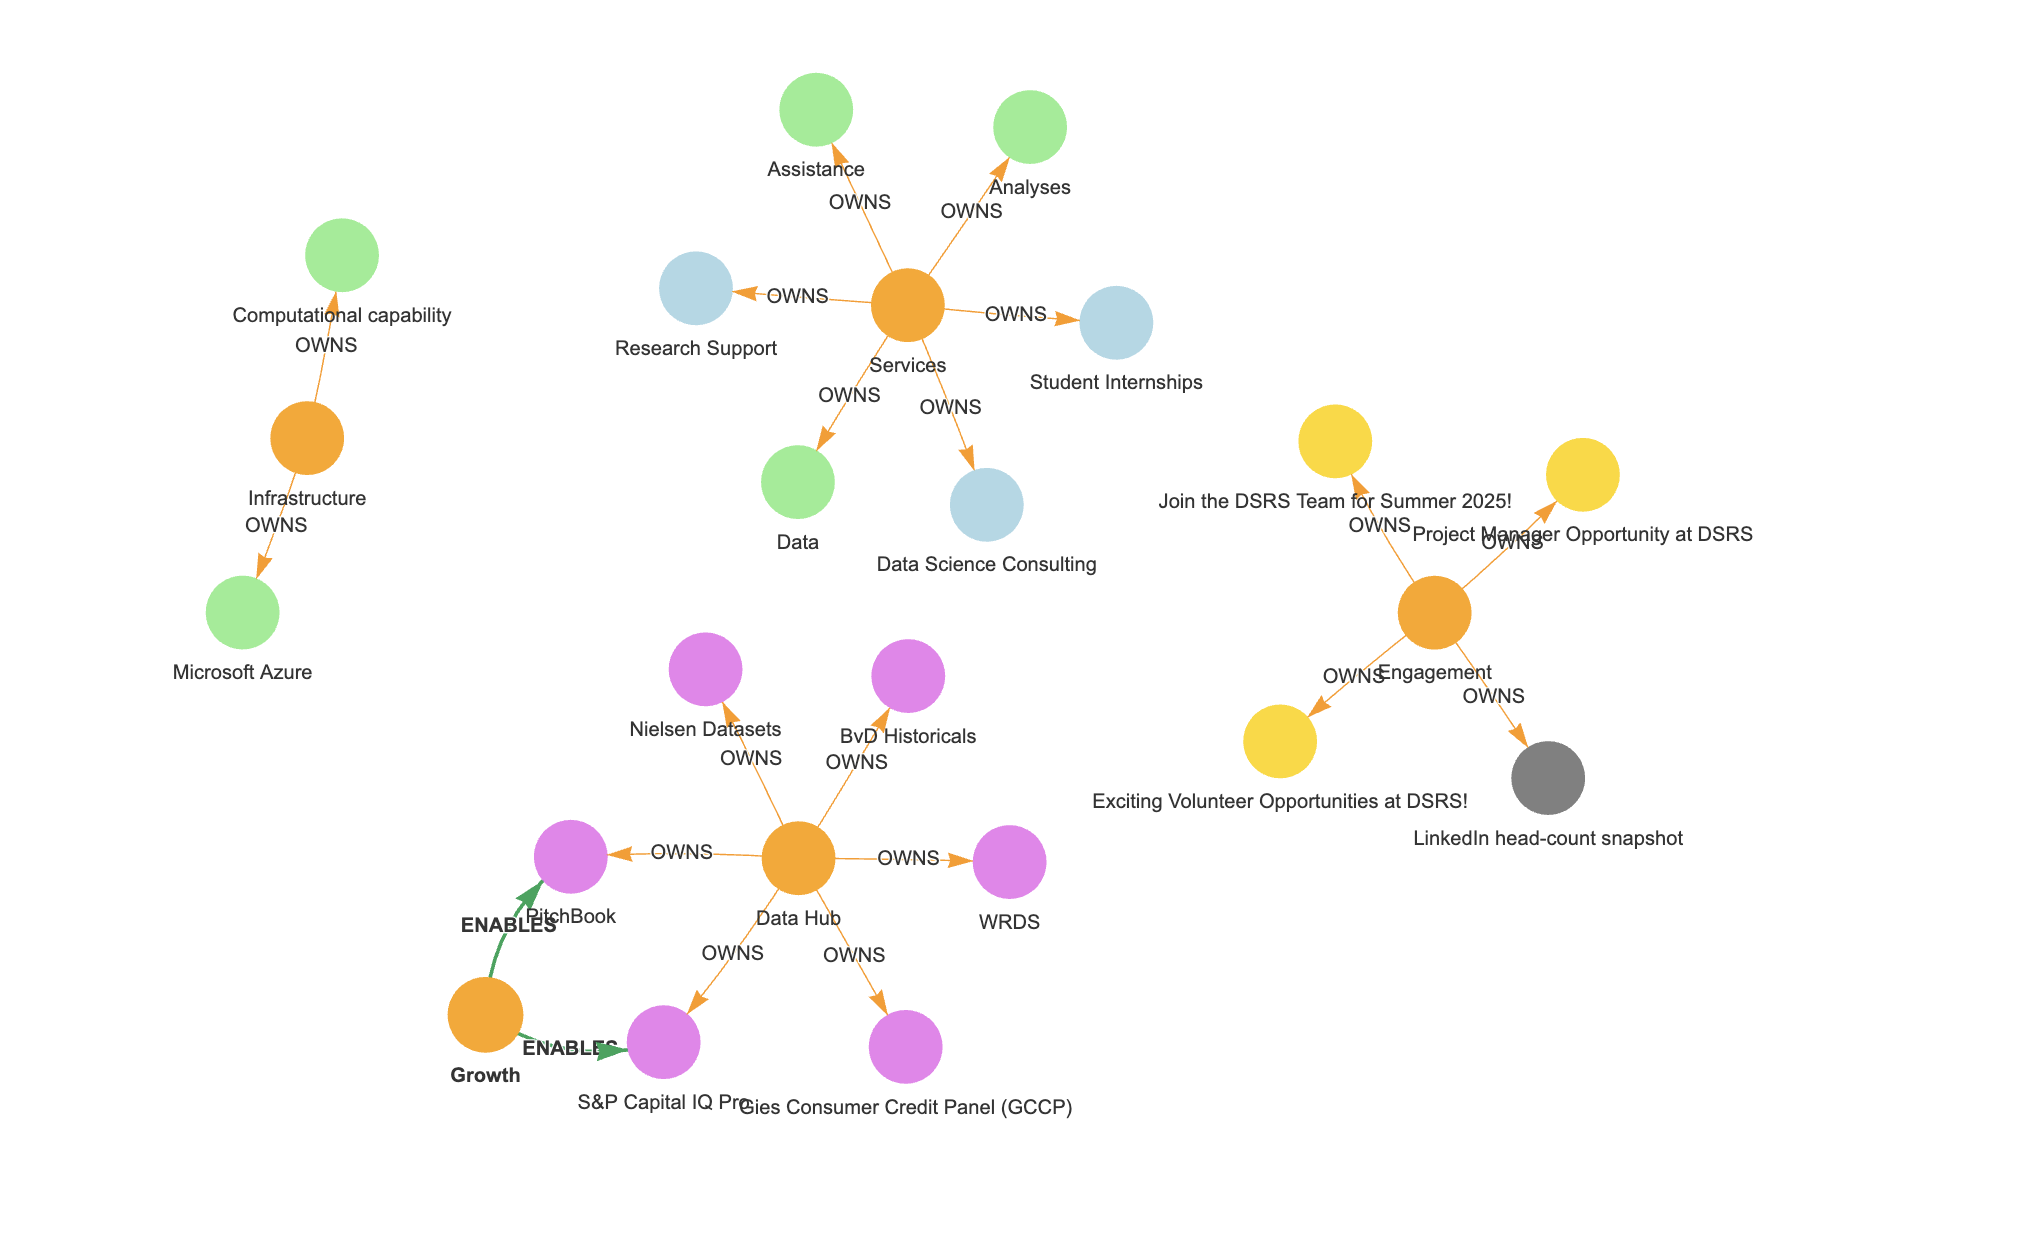

**Navigating the Graph**  
   - **Pan / Zoom**: Scroll to zoom in/out. Click & drag to pan around.  
   - **Drag Nodes**: Left‐click any node and drag it to reposition.  
   - **Hover Over Node**: A tooltip will appear showing all of that node’s attributes (e.g., `id`, `title`, `type`, `summary`, `source`, `last_updated`).  
   - **Hover Over Edge**: You will see the “relation” (either `OWNS` or `ENABLES`) printed as an edge label.  
   - **Click on a Node**: Clicking a node while holding the mouse button down will pin/unpin that node—useful to temporarily fix a cluster in place.

### Graph description
- Five orange nodes represent DSRS sub-units: Data Hub, Services, Infrastructure, Engagement, Growth.
- Blue nodes are service offerings owned by “Services”.
- Green nodes are capabilities/resources (e.g., Microsoft Azure, Analyses, Data).
- Violet nodes are datasets connected to “Data Hub”.
- Gold nodes are LinkedIn news items published by “Engagement”.
- A grey node is a metric (LinkedIn head-count snapshot) linked from “Engagement”.
- Arrow labels show the relationship type:  
  * **OWNS** – sub-unit owns the child node.  
  * **ENABLES** – Growth enables access to external datasets.  
  * **PUBLISHES** – Engagement publishes news or metrics.

### How to view the graph file
1. Locate **dsrs_graph.html** in the notebook’s file browser (left sidebar).  
2. Double-click the file to open the interactive graph in a new tab.  
3. To download: right-click the file name ➜ **Download**; open the saved HTML in any browser.


In [18]:
print(df[["id", "title"]].sort_values("title").to_string(index=False))

            id                                     title
        cap_02                                  Analyses
        cap_01                                Assistance
         ds_01                           BvD Historicals
        cap_04                  Computational capability
        cap_03                                      Data
        sub_01                                  Data Hub
        svc_03                   Data Science Consulting
        sub_04                                Engagement
       news_03 Exciting Volunteer Opportunities at DSRS!
         ds_02         Gies Consumer Credit Panel (GCCP)
        sub_05                                    Growth
        sub_03                            Infrastructure
       news_01       Join the DSRS Team for Summer 2025!
metric_2025_05              LinkedIn head-count snapshot
        cap_05                           Microsoft Azure
         ds_05                          Nielsen Datasets
         ds_03                 

In [19]:
# 1. Show everything Growth ENABLES
print("Growth leverages:", list(G.successors("sub_05")))

# 2. Simple centrality ranking
dc = nx.degree_centrality(G)
print(sorted(dc.items(), key=lambda x: -x[1])[:5])

# 3. Timeline plot of news posts
df_news = df[df["type"]=="news"][["title","post_date"]]
display(df_news)

Growth leverages: ['ds_03', 'ds_06']
[('sub_01', 0.2727272727272727), ('sub_02', 0.2727272727272727), ('sub_04', 0.18181818181818182), ('sub_03', 0.09090909090909091), ('sub_05', 0.09090909090909091)]


,title,post_date
19,Join the DSRS Team for Summer 2025!,2025-05-10
20,Project Manager Opportunity at DSRS,2024-11-01
21,Exciting Volunteer Opportunities at DSRS!,2024-09-30


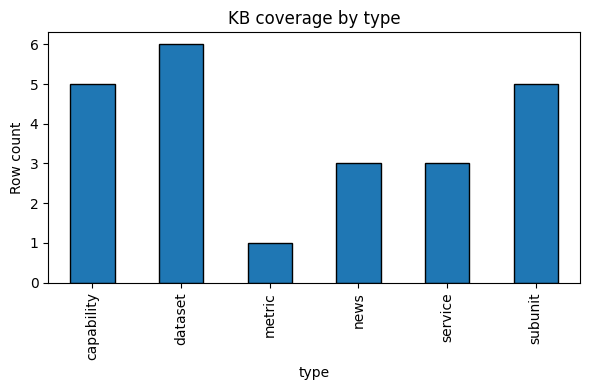

In [20]:
import matplotlib.pyplot as plt

df['type'].value_counts().sort_index().plot(
    kind='bar', figsize=(6,4), edgecolor='black'
)
plt.ylabel("Row count")
plt.title("KB coverage by type")
plt.tight_layout()
plt.show()


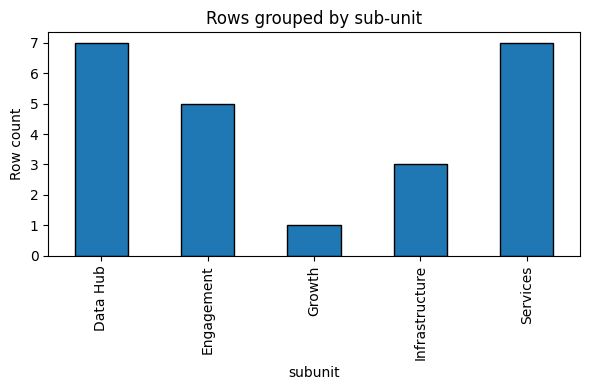

In [21]:
(df['subunit']
     .value_counts()
     .reindex(sorted(df['subunit'].unique()))
     .plot(kind='bar', figsize=(6,4), edgecolor='black'))

plt.ylabel("Row count")
plt.title("Rows grouped by sub-unit")
plt.tight_layout()
plt.show()

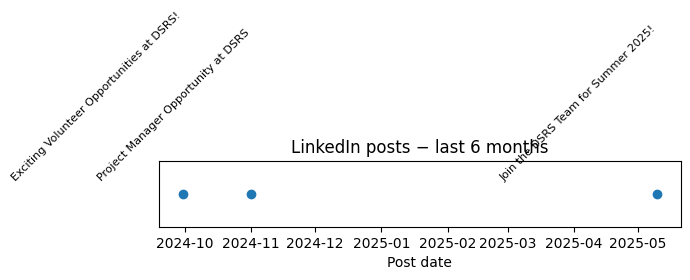

In [22]:
df_news = df[df['type'] == 'news'].copy()
df_news['post_date'] = pd.to_datetime(df_news['post_date'])
df_news = df_news.sort_values('post_date')

plt.figure(figsize=(7,2.5))
plt.plot(df_news['post_date'], [1]*len(df_news), marker='o', linestyle='')
for _, row in df_news.iterrows():
    plt.text(row['post_date'], 1.02, row['title'], rotation=45, ha='right', va='bottom', fontsize=8)

plt.yticks([]); plt.xlabel("Post date"); plt.title("LinkedIn posts − last 6 months")
plt.tight_layout(); plt.show()

In the above visualization we can see that:

* Each dot is one DSRS LinkedIn post from the last six months, positioned on its publish date.  
* We have **three posts** during the window — October 2024, November 2024, and May 2025.  
* The two-month gap (Oct → Nov) followed by a long quiet period (Nov → May) suggests irregular posting cadence; a regular monthly schedule could keep followers more engaged.  

In short, the KB can already answer **“When did DSRS last post?”** and highlight posting frequency at a glance.


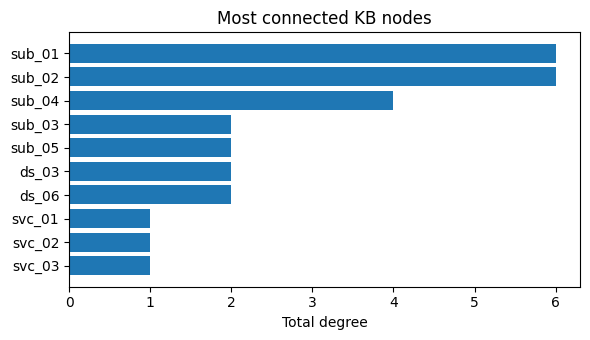

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

deg = dict(G.degree())
# Pull top-10 busiest nodes
top10 = sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
labels, values = zip(*top10)

plt.figure(figsize=(6,3.5))
plt.barh(labels[::-1], values[::-1])        # reverse for descending top→bottom
plt.xlabel("Total degree")
plt.title("Most connected KB nodes")
plt.tight_layout()
plt.show()